# Import statements

In [1]:
from pytao import Tao
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import re
import io
from os import path,environ
import pandas as pd
import random
from IPython.display import display, clear_output
import bayes_opt

from pmd_beamphysics import ParticleGroup
from pmd_beamphysics.statistics import resample_particles

from UTILITY_plotNMM import plotNMM, slicePlotNMM
from UTILITY_linacPhaseAndAmplitude import getLinacMatchStrings, setLinacPhase, setLinacGradientAuto
from UTILITY_modifyAndSaveInputBeam import modifyAndSaveInputBeam
from UTILITY_setLattice import setLattice

import os
filePath = os.getcwd()
%env FACET2_LATTICE {filePath}
#%env FACET2_LATTICE /Users/nmajik/Documents/SLAC/slacsyncgit/bmadExample

print('Make sure enviornment was set!:  ', environ['FACET2_LATTICE']) 

env: FACET2_LATTICE=/Users/nmajik/Documents/SLAC/slacsyncgit/bmadExample
Make sure enviornment was set!:   /Users/nmajik/Documents/SLAC/slacsyncgit/bmadExample


# Start tao

In [2]:
tao=Tao('-init {:s}/bmad/models/f2_elec/tao.init -noplot'.format(environ['FACET2_LATTICE'])) 
#tao=Tao('-init {:s}/bmad/models/f2_elec/tao.init'.format(environ['FACET2_LATTICE'])) 

#Need to explicitly add non-MARKER places to save beam...
tao.cmd("set beam add_saved_at = DTOTR, XTCAVF")

[]

# Plot single particle twiss

In [3]:
#Helper functions for single particle Twiss plots

def floorplan_sorter(ele):
    """
    ele is an element of a pandas dictionary made from the bmad floorplan (made to look like an elegant floorplan from my "elegant_helpers" file). This sorter parses the columns to make a "patch" for plotting purposes. See floorplan_patches().
    """
    if ele['ds']==0:
        ele['ds']=0.05
    s0=float(ele['s'])-float(ele['ds'])
    x=float(ele['X'])*2-0.5
    
    if (re.search('DRIF',ele.ElementType.upper())!=None)|(ele.ElementType.upper()=='MARK'):
        patchColor=None
        patch=None
    elif (re.search('BEND',ele.ElementType.upper())!=None)|(re.search('KICK',ele.ElementType.upper())!=None):
        patchColor='r'
        patch=mpatches.Rectangle(xy=(s0,x),width=float(ele['ds']),height=1,color=patchColor,lw=0,ls=None)
    elif re.search('XL',ele.ElementName.upper())!=None:
        patchColor=colorlist2[1]
        patch=mpatches.Rectangle(xy=(s0,x),width=float(ele['ds']),height=1,color=patchColor,lw=0,ls=None)
    elif 'QUAD' in ele.ElementType.upper():
        patchColor=colorlist[2]
        patch=mpatches.Rectangle(xy=(s0,x),width=float(ele['ds']),height=1,color=patchColor,lw=0,ls=None)
    elif 'SEXT' in ele.ElementType.upper():
        patchColor="#204337"
        patch=mpatches.Rectangle(xy=(s0,x),width=float(ele['ds']),height=1,color=patchColor,lw=0,ls=None)
    elif 'RFCW' in ele.ElementType.upper() or 'CAV' in ele.ElementType.upper():
        string_lst=['L3_10_50','L3_10_25','L2_10_25','L2_10_50','X1_Xband','L1_10_25','L1_9_25','L1_9_50'] #nonzero voltage
        if re.findall(r"(?=("+'|'.join(string_lst)+r"))",ele.ElementName)!=None:
            patchColor="#CD7F32"
            patch=mpatches.Rectangle(xy=(s0,x),width=float(ele['ds']),height=0.5,color=patchColor,lw=0,ls=None)
    elif re.search('^UM',ele.ElementName)!=None:
        patchColor=colorlist[1]
        patch=mpatches.Rectangle(xy=(s0,x),width=float(ele['ds']),height=1,color=patchColor,lw=0,ls=None)
    else:
        patchColor=None
        patch=None
        
    return patch

def floorplan_patches(floorplan,zbounds=None):
    """
    This function returns a list of patches to be plotted (patches) and a list of patches for the legend (leg_patches). If zbounds=[zmin,zmax] is given then the plot is restricted to the bounds. 
    
    Useage:
    
    fp=SDDS(0)
    fp.load(LCLS2scS.flr)
    __,floorplan=sdds2pd(fp)
    patches,leg_patches=flooplan_patches(floorplan,[3425,3750])
    """
    if zbounds==None:
        zbounds=[flooplan['s'].min(),flooplan['s'].max()]
    sFloor=floorplan.s.astype(dtype=float);
    sFloor=sFloor.values
    ii=0;
    patches=[];
    for index, ele in (floorplan.iloc[(sFloor>zbounds[0])&(sFloor<zbounds[1])]).iterrows():
        patches.append(floorplan_sorter(ele))
    
    quad_patch = mpatches.Patch(color=colorlist[2], label='Quad')
    sext_patch = mpatches.Patch(color="#204337", label='Linac')
    bend_patch = mpatches.Patch(color='red', label='Bend')
    leg_patches=[quad_patch,sext_patch,bend_patch];
    return patches,leg_patches
    
def floorplan_plot(ax_fp,floorplan,zmin=0,zmax=2000):  
    """
    This function plots "patches" for basic elements in the lattice. This can help identify what you're looking at in a "z-plot".
    """
    
    patches,leg_patches=floorplan_patches(floorplan,[zmin,zmax])

    for p in patches:
        if p!=None:
            ax_fp.add_patch(p)

    ax_fp.plot((zmin,zmax),(0,0),'k',alpha=0.0)
    ax_fp.tick_params(axis='x',direction='out',length=15,width=6,color='k',bottom=True)
    plt.yticks([])
    #ax_fp.set_ylim([-3,1])
    ax_fp.set_xlim([zmin,zmax])
    return ax_fp
    
def format_longitudinal_plot(fig):
    """
    This function helps format a "z-plot" by providing axes for the main plot and for the a floorplan_plot. It also plots the floorplan.
    """
    outer_grid=fig.add_gridspec(5,1,hspace=0)
    ax=fig.add_subplot(outer_grid[0:4,:])
    ax_fp=fig.add_subplot(outer_grid[4,:], sharex = ax)
    floorplan_plot(ax_fp,floorplan)
    plt.sca(ax)
    
    return ax, ax_fp 

In [4]:
elements=tao.lat_ele_list();

floorplan=pd.read_csv(
    io.StringIO('\n'.join(tao.show('lat -all -floor_coords -tracking_elements')[3:-5])), 
    sep="[\s\n]+",
    engine='python',
    names=['Index','ElementName','ElementType','s','ds','X','Y','Z','Theta','Phi','Psi'])
floorplan.drop(0,inplace=True);

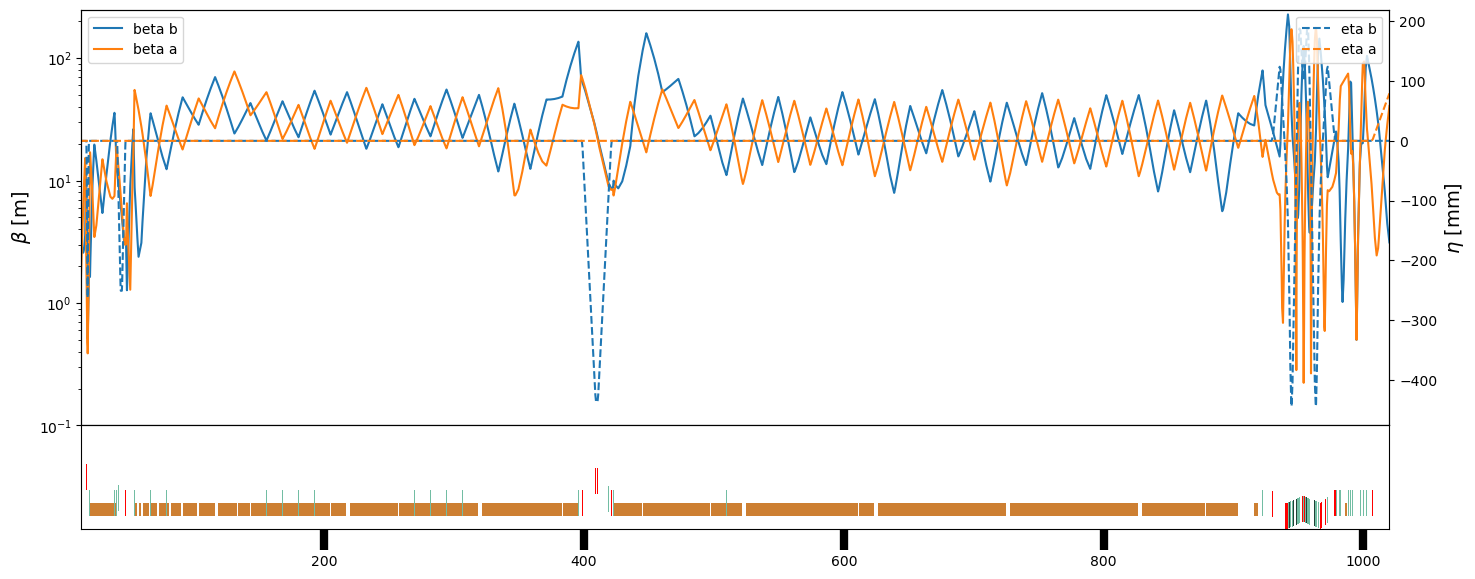

In [5]:
colorlist=['#982649', '#6BCAE2', '#72bda3', '#ed6a5a', '#533a71']
colorlist2=['#E2836A','#6a7ee2','#74e26a']




#Get twiss functions
tao.cmd('set global lattice_calc_on = T')
s=np.array([tao.lat_list(x,'ele.s')[0] for x in floorplan.Index])
x=np.array([tao.lat_list(x,'orbit.floor.x')[0] for x in floorplan.Index])
beta_y=np.array([tao.lat_list(x,'ele.a.beta')[0] for x in floorplan.Index])
beta_x=np.array([tao.lat_list(x,'ele.b.beta')[0] for x in floorplan.Index])
etot=np.array([tao.lat_list(x,'ele.e_tot')[0] for x in floorplan.Index])
eta_y=np.array([tao.lat_list(x,'ele.y.eta')[0] for x in floorplan.Index])
eta_x=np.array([tao.lat_list(x,'ele.x.eta')[0] for x in floorplan.Index])


fig = plt.figure(num=1,figsize=[3.375*5,3.375*2])
fig.clf()
ax,ax_fp=format_longitudinal_plot(fig)

ax.semilogy(s,beta_x,label='beta b')
ax.semilogy(s,beta_y,label='beta a')
plt.legend(loc=2)
ax.set_ylim([0.1,250])
ax_r=ax.twinx()
ax_r.plot(s,eta_x*1e3,'C0--',label='eta b')
ax_r.plot(s,eta_y*1e3,'C1--',label='eta a')
plt.legend(loc=1)
#ax_r.plot(s,beta_y,'k--')
#ax_r.plot(s,np.array([tao.lat_list(x,'ele.x.eta')[0] for x in floorplan.Index]),'--')

ax.set_facecolor('w')
zmin=13
zmax=1020

ax.set_xlabel('Z [m]',fontsize=14)
ax.set_ylabel(r'$\beta$ [m]',fontsize=14)
ax_r.set_ylabel(r'$\eta$ [mm]',fontsize=14)

ax.set_xlim([zmin,zmax])
ax_fp.set_ylim([-1,3])

plt.show()
#fig.savefig('beamline',transparent=False,bbox_inches='tight', dpi=300)

# Beam construction

## Import beam

In [6]:
lastTrackedElement = "end"
tao.cmd(f'set beam_init track_end = {lastTrackedElement}')
#Can see present track_start and track_end values with `show beam`


#Optional: Enable CSR
tao.cmd(f'call {filePath}/bmad/models/f2_elec/scripts/Activate_CSR.tao')
#tao.cmd('csron')
tao.cmd('csroff')

[]

In [7]:
inputBeamFilePath = f'{filePath}/bmad/beams/nmmToL0AFEND_2bunch_2024-02-16Clean/2024-02-16_2bunch_1e5Downsample_nudgeWeights_driverOnly_2023-05-16InjectorMatch.h5'


modifyAndSaveInputBeam(
    inputBeamFilePath,
    numMacroParticles = 10000
)

tao.cmd(f'set beam_init position_file={filePath}/bmad/beams/activeBeamFile.h5')
tao.cmd('reinit beam')

#Set lattice to my latest default config
setLattice(tao)

tao.cmd('set global track_type = beam') #set "track_type = single" to return to single particle
tao.cmd('set global track_type = single') #return to single to prevent accidental long re-evaluation

[]

In [8]:
PPENT =  ParticleGroup(data=tao.bunch_data("PENT"))

sigmaX = PPENT.std("x")
sigmaY = PPENT.std("y")
sigmaZ = PPENT.std("t")*3e8 #Cannot use std.("z") since Bmad dumps all particles at same z

print(f"{sigmaX}, {sigmaY}, {sigmaZ}")

8.064956976231661e-05, 1.7378005066577988e-05, 1.0446438361172507e-05


# Bayesian optimization

## Utility functions

In [9]:
#From the more general modifyLaunchBeamAndPropagateToMFFF(...)
def propagateToMFFF(
    centerXYatMFFF = False    
): 

    ######################################################################################
    #First import "clean" beam and do modification at launch point
    ######################################################################################

    inputBeamFilePath = f'{filePath}/bmad/beams/nmmToL0AFEND_2bunch_2024-02-16Clean/2024-02-16_2bunch_1e5Downsample_nudgeWeights_driverOnly_2023-05-16InjectorMatch.h5'

    tao.cmd('reinit beam')

    P = modifyAndSaveInputBeam(
        inputBeamFilePath,
        numMacroParticles = 10000,
        #betaX = launchBetaX,
        #alphaX = launchAlphaX,
        #betaY = launchBetaY,
        #alphaY = launchAlphaY
    )

    P.write(f'{filePath}/bmad/beams/activeBeamFile.h5')
    inputBeamFilePath = f'{filePath}/bmad/beams/activeBeamFile.h5'

    ##################################
    #Propagate to MFFF and save result
    ##################################
    tao.cmd(f'set beam_init track_start = L0AFEND')
    lastTrackedElement = "MFFF"
    tao.cmd(f'set beam_init track_end = {lastTrackedElement}')

    tao.cmd(f'set beam_init position_file={filePath}/bmad/beams/activeBeamFile.h5')
    tao.cmd('reinit beam')

    tao.cmd('set global track_type = beam') #set "track_type = single" to return to single particle
    tao.cmd('set global track_type = single') #return to single to prevent accidental long re-evaluation

    P = ParticleGroup(data=tao.bunch_data(lastTrackedElement))

    ##################################
    #Optional!! Center in x and y
    ##################################
    if centerXYatMFFF:
        P.x = P.x - np.mean(P.x)
        P.y = P.y - np.mean(P.y)
        P.px = P.px - np.mean(P.px)
        P.py = P.py - np.mean(P.py)
    
    P.write(f'{filePath}/bmad/beams/activeBeamFile.h5')

    return

In [10]:
def prepareToSimulateFromMFFFtoEnd():
    #####################################################
    #Import the MFFF beam and prepare to simulate to end
    #####################################################
    tao.cmd(f'set beam_init position_file={filePath}/bmad/beams/activeBeamFile.h5')
    tao.cmd(f'set beam_init track_start = MFFF')
    tao.cmd(f'set beam_init track_end = end')
    tao.cmd('reinit beam')

    return

## Optimizer functions

In [11]:
#If we're not making changes upstream, we can just calculate once
makingChangesUpstreamOfMFFF = False

if not makingChangesUpstreamOfMFFF:
    setLattice(tao) #Set lattice to current default config
    propagateToMFFF(centerXYatMFFF = True)
    prepareToSimulateFromMFFFtoEnd()


def specificOptimizer(
    self,
    **kwargs
):
    

    badValue = -1 #The value returned for illegal config
    
    try: #This try block deals with bad configurations. Instead of causing the optimizer to halt we now 'except' a low value
        setLattice(tao, **kwargs)

    except:
        return badValue

    if makingChangesUpstreamOfMFFF:

        try:
            propagateToMFFF(centerXYatMFFF = True)
            prepareToSimulateFromMFFFtoEnd()
            #tao.cmd('set global track_type = beam') #set "track_type = single" to return to single particle
            #tao.cmd('set global track_type = single') #return to single to prevent accidental long re-evaluation
        
        except:
            return badValue

    try:
        tao.cmd("set ele XTCAVF VOLTAGE = 10e6")
        tao.cmd("set ele XTCAVF PHI0 = 0")
        tao.cmd('set global track_type = beam') #set "track_type = single" to return to single particle
        tao.cmd('set global track_type = single') #return to single to prevent accidental long re-evaluation

    except:
        return badValue

    MFFFNumLiveParticles = tao.bunch_params("MFFF")['n_particle_live']
    DTOTRSigmaXValTCAVOn = tao.bunch_params("DTOTR")['twiss_sigma_x']
    DTOTRBetaXValTCAVOn = tao.bunch_params("DTOTR")['twiss_beta_x']
    DTOTRNumLiveParticlesTCAVOn = tao.bunch_params("DTOTR")['n_particle_live']
    
    
    
    try:
        tao.cmd("set ele XTCAVF VOLTAGE = 0e6")
        tao.cmd("set ele XTCAVF PHI0 = 0")
        tao.cmd('set global track_type = beam') #set "track_type = single" to return to single particle
        tao.cmd('set global track_type = single') #return to single to prevent accidental long re-evaluation

    except:
        return badValue
    
    DTOTRSigmaXValTCAVOff = tao.bunch_params("DTOTR")['twiss_sigma_x']
    DTOTRBetaXValTCAVOff = tao.bunch_params("DTOTR")['twiss_beta_x']
    DTOTRNumLiveParticlesTCAVOff = tao.bunch_params("DTOTR")['n_particle_live']



    
    maximizeMe = DTOTRSigmaXValTCAVOn / DTOTRSigmaXValTCAVOff
    #maximizeMe = tao.bunch_params("DTOTR")['twiss_sigma_x']
 
    
    
    bigCost = -1000
    betaThresh = 1e4

    """
    quadNameList = ["Q5FF", "Q4FF", "Q3FF", "Q2FF", "Q1FF", "Q0FF", "Q0D", "Q1D", "Q2D"]
    #This is just a toy version for now; impose cost for beams that are too big
    for quadName in quadNameList: 
        #if tao.ele_twiss(quadName)['beta_a'] > 1e4: maximizeMe += bigCost
        #if tao.ele_twiss(quadName)['beta_b'] > 1e4: maximizeMe += bigCost
        
        #Instead of a fixed amount, let there be some gradient
        if tao.ele_twiss(quadName)['beta_a'] > betaThresh: maximizeMe += -1*1e-2*(tao.ele_twiss(quadName)['beta_a']-betaThresh)
        if tao.ele_twiss(quadName)['beta_b'] > betaThresh: maximizeMe += -1*1e-2*(tao.ele_twiss(quadName)['beta_b']-betaThresh)  
    """

    #Use charge loss to impose cost
    worstNumLiveParticles = min(DTOTRNumLiveParticlesTCAVOn, DTOTRNumLiveParticlesTCAVOff)
    chargeFractionLiving = worstNumLiveParticles / MFFFNumLiveParticles

    if chargeFractionLiving < 0.98:
        maximizeMe += bigCost * (1-chargeFractionLiving)

    
    #Collect desired data as a pandas Series
    tmpData = pd.Series(
        
        kwargs | { 

        "MFFFNumLiveParticles": MFFFNumLiveParticles,
        
        "DTOTRSigmaXValTCAVOn": DTOTRSigmaXValTCAVOn,
        "DTOTRSigmaXValTCAVOff": DTOTRSigmaXValTCAVOff,
        "DTOTRNumLiveParticlesTCAVOn": DTOTRNumLiveParticlesTCAVOn,
            
        "DTOTRBetaXValTCAVOn": DTOTRBetaXValTCAVOn,
        "DTOTRBetaXValTCAVOff": DTOTRBetaXValTCAVOff,
        "DTOTRNumLiveParticlesTCAVOff": DTOTRNumLiveParticlesTCAVOff,
            
        "maximizeMe": maximizeMe
    #   "finalEmit": finalEmit,
    #   "initialBeam": ParticleGroup(data=tao.bunch_data('L0AFEND')),
    #   "finalBeam": ParticleGroup(data=tao.bunch_data(lastTrackedElement))
    #    "fig": outputFig
    })

    
    self.history = pd.concat([self.history, tmpData.to_frame().T])

    self.updatePlot()
    
    return maximizeMe



def optimizerWrapper( self, 
                     #L1PhaseSet, L2PhaseSet, 
                     Q5FFkG, Q4FFkG, Q3FFkG, 
                     Q2FFkG, Q1FFkG, Q0FFkG, 
                     Q0DkG, Q1DkG, Q2DkG, 
                     **kwargs ):
    return specificOptimizer(
        self,
        **{
            #"L1PhaseSet": L1PhaseSet, 
            #"L2PhaseSet": L2PhaseSet,
            "Q5FFkG": Q5FFkG,
            "Q4FFkG": Q4FFkG,
            "Q3FFkG": Q3FFkG,
            "Q2FFkG": Q2FFkG,
            "Q1FFkG": Q1FFkG,
            "Q0FFkG": Q0FFkG,
            "Q0DkG": Q0DkG,
            "Q1DkG": Q1DkG,
            "Q2DkG": Q2DkG,
        }#
    )

## Optional: Manually check some settings

In [12]:
# setLattice(tao, **{
#             "Q5FFkG": -192,
#             "Q4FFkG": -162,
#             "Q3FFkG": 106,
#             "Q2FFkG": 121,
#             "Q1FFkG": -209,
#             "Q0FFkG": 121,
#             "Q0DkG": -139,
#             "Q1DkG": 225,
#             "Q2DkG": -139
# })
setLattice(tao)


tao.cmd('set global track_type = beam') #set "track_type = single" to return to single particle
tao.cmd('set global track_type = single') #return to single to prevent accidental long re-evaluation

XTCAVSigmaX = tao.bunch_params("XTCAVF")['twiss_sigma_x']
MFFFNumLiveParticles = tao.bunch_params("MFFF")['n_particle_live']
DTOTRNumLiveParticlesTCAVOn = tao.bunch_params("DTOTR")['n_particle_live']

print(1e6*XTCAVSigmaX)
print(DTOTRNumLiveParticlesTCAVOn)

87.0929388005807
10000


In [13]:
setLattice(tao)

tao.cmd("set ele XTCAVF VOLTAGE = 10e6")
tao.cmd("set ele XTCAVF PHI0 = 0")
tao.cmd('set global track_type = beam') #set "track_type = single" to return to single particle
tao.cmd('set global track_type = single') #return to single to prevent accidental long re-evaluation


MFFFNumLiveParticles = tao.bunch_params("MFFF")['n_particle_live']
DTOTRSigmaXValTCAVOn = tao.bunch_params("DTOTR")['twiss_sigma_x']
DTOTRBetaXValTCAVOn = tao.bunch_params("DTOTR")['twiss_beta_x']
DTOTRNumLiveParticlesTCAVOn = tao.bunch_params("DTOTR")['n_particle_live']


tao.cmd("set ele XTCAVF VOLTAGE = 0e6")
tao.cmd("set ele XTCAVF PHI0 = 0")
tao.cmd('set global track_type = beam') #set "track_type = single" to return to single particle
tao.cmd('set global track_type = single') #return to single to prevent accidental long re-evaluation


DTOTRSigmaXValTCAVOff = tao.bunch_params("DTOTR")['twiss_sigma_x']
DTOTRBetaXValTCAVOff = tao.bunch_params("DTOTR")['twiss_beta_x']
DTOTRNumLiveParticlesTCAVOff = tao.bunch_params("DTOTR")['n_particle_live']




maximizeMe = DTOTRSigmaXValTCAVOn / DTOTRSigmaXValTCAVOff

print(maximizeMe)

1.1907093784288227


## Do optimization

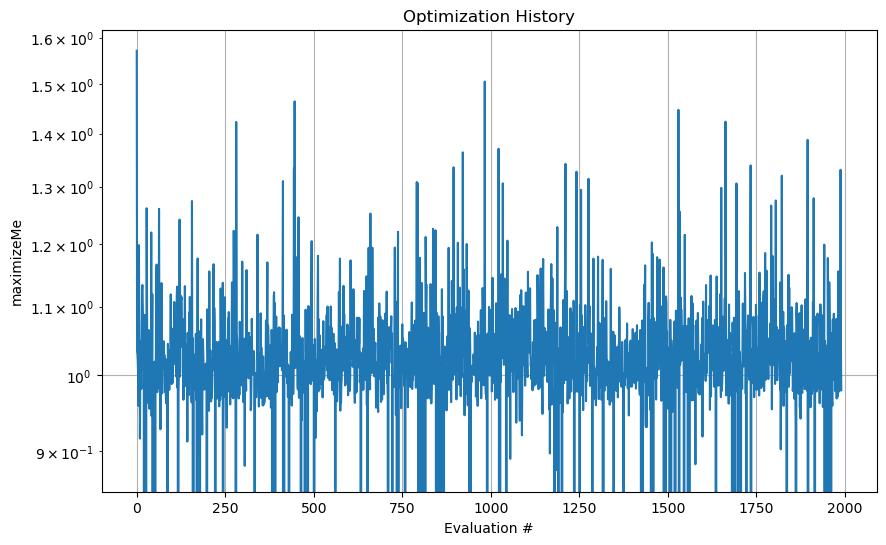

| 2001      | 0.9796    | -27.0     | 149.4     | 53.88     | -148.4    | -166.5    | 19.88     | 329.9     | -170.9    | -183.7    |
        Q5FFkG      Q4FFkG      Q3FFkG      Q2FFkG      Q1FFkG      Q0FFkG  \
0  -243.609969 -376.496482  191.414056   78.502232  -38.898421   10.930414   
0   -68.560924  -30.459313  157.363163   49.185502 -187.367043  119.835814   
0   -50.717669 -246.834373   86.685669    0.465195 -127.863463  160.851418   
0  -209.765220 -336.094488  296.738080   96.048680 -175.840145  134.367876   
0  -123.978223 -192.162508  279.154734  145.136559 -127.461298  148.659976   
..         ...         ...         ...         ...         ...         ...   
0  -191.341531  -26.811937  205.513500  146.968347 -153.017600  110.579986   
0  -226.701508 -146.090414  170.167537  132.997780 -149.707075   36.372270   
0  -204.107067  -76.642748  100.968698  118.710084 -214.381684   97.780204   
0  -179.800282 -174.126214   98.959654   55.228373  -87.754324   83.503759   
0  -183.

In [14]:
class OptimizationProblem:
    def __init__(self):
        self.history = pd.DataFrame()

    def updatePlot(self):
        plotKey = "maximizeMe"
        
        # Clear the previous figure to prevent flickering
        clear_output(wait=True)
        
        # Create a new figure
        plt.figure(figsize=(10, 6))
        #plt.plot(self.history.index, self.history['finalEmit'], '-o', markersize=8)
        plt.plot(np.arange(len(self.history[plotKey])), self.history[plotKey], '-')
        plt.title('Optimization History')
        plt.xlabel('Evaluation #')
        plt.ylabel(plotKey)
        plt.yscale('log')
        plt.grid(True)
        
        # Show plot
        plt.show()


# Attach the function to the class as a method
OptimizationProblem.optimizerWrapper = optimizerWrapper

# Instantiate the optimization problem
problem = OptimizationProblem()



def makeBoundsTuple(range, center): return tuple(sorted( ( (1-range)*center, (1+range)*center) ) )
    
# Bounded region of parameter space
#2024-05-15: Out of abundance of caution, always comment out unused vars, even if using **kwargs stops errors from being thrown
pbounds = {
    #'L1PhaseSet': (-30, 10),
    #'L2PhaseSet': (-60, 10),
    #'L1PhaseSet': makeBoundsTuple(0.2, -30),
    #'L2PhaseSet': makeBoundsTuple(0.2, -40),
    #'L2EnergyOffset': (-200e6, 200e6),
    #'L3EnergyOffset': (-200e6, 200e6),
    
    #Full SCP ranges
    'Q5FFkG': (-256, 0), 
    'Q4FFkG': (-446, 0), 
    'Q3FFkG': (0, 457),
    'Q2FFkG': (0, 167),
    'Q1FFkG': (-257, 0),
    'Q0FFkG': (0, 167),
    'Q0DkG': (-239, 0),
    'Q1DkG': (0, 386),
    'Q2DkG': (-223, 0),

    # 'Q5FFkG': makeBoundsTuple(0.2, -70), 
    # 'Q4FFkG': makeBoundsTuple(0.2, -70),
    # 'Q3FFkG': makeBoundsTuple(0.2, 106),
    # 'Q2FFkG': makeBoundsTuple(0.2, 112),
    # 'Q1FFkG': makeBoundsTuple(0.2, -224),
    # 'Q0FFkG': makeBoundsTuple(0.2, 112),
    # 'Q0DkG':  makeBoundsTuple(0.2, -115),
    # 'Q1DkG':  makeBoundsTuple(0.2, 180),
    # 'Q2DkG':  makeBoundsTuple(0.2, -115),



}





optimizer = bayes_opt.BayesianOptimization(
    f=problem.optimizerWrapper,
    pbounds=pbounds,
    random_state=7,
    allow_duplicate_points=True #2024-04-26 it was whining about this 
)

#Initial point(s) to check
optimizer.probe(
    params={
 'Q5FFkG': -42.54626076534884,
 'Q4FFkG': -185.15367113190788,
 'Q3FFkG': 333.8516888317743,
 'Q2FFkG': 126.98548388666792,
 'Q1FFkG': -233.53145255938017,
 'Q0FFkG': 113.27243178699172,
 'Q0DkG': -181.72983138107764,
 'Q1DkG': 285.80493800792226,
 'Q2DkG': -107.0494897569018,
},
    lazy=True,
)

#Refer to https://bayesian-optimization.github.io/BayesianOptimization/exploitation_vs_exploration.html
#and https://github.com/bayesian-optimization/BayesianOptimization/blob/master/bayes_opt/bayesian_optimization.py
boInitialKappa = 1 + 0*10.
boFinalKappa = 0.001 + 0*0.1
boNumIter = 3000
boKappaDecay = (boFinalKappa / boInitialKappa)**(1/boNumIter)

acquisition_function = bayes_opt.util.UtilityFunction(kind='ucb',
                                   kappa=boInitialKappa,         #Default 2.576
                                   xi=0.0,              #Default 0
                                   kappa_decay=boKappaDecay,       #Default 0
                                   kappa_decay_delay=0  #Default 0                     
                                          )


optimizer.maximize(
    init_points=0, #Initial, random points
    n_iter=boNumIter,
    acquisition_function=acquisition_function
)


#print(res)
print(problem.history) 

## Check out results

In [15]:
problem.history = problem.history.sort_values(by='maximizeMe', ascending=False)
problem.history.to_csv('output_data.csv', index=False)

bestConfigData = problem.history.iloc[0]
bestConfigDict = bestConfigData.to_dict()

print( bestConfigData ) 

#Using triple quotes lets us use " inside the f-string
#print(f"""\n{1e6*bestConfigData["sigmaX"]}, {1e6*bestConfigData["sigmaY"]}, {1e6*bestConfigData["sigmaZ"]}""")


setLattice(tao, **bestConfigDict)



tao.cmd('set global track_type = beam') #set "track_type = single" to return to single particle
tao.cmd('set global track_type = single') #return to single to prevent accidental long re-evaluation

PPENT =  ParticleGroup(data=tao.bunch_data("PENT"))
PPENT = PPENT[PPENT.status==1]

Q5FFkG                           -243.609969
Q4FFkG                           -376.496482
Q3FFkG                            191.414056
Q2FFkG                             78.502232
Q1FFkG                            -38.898421
Q0FFkG                             10.930414
Q0DkG                            -139.502619
Q1DkG                             311.528847
Q2DkG                            -122.839466
MFFFNumLiveParticles            10000.000000
DTOTRSigmaXValTCAVOn                0.000861
DTOTRSigmaXValTCAVOff               0.000548
DTOTRNumLiveParticlesTCAVOn     10000.000000
DTOTRBetaXValTCAVOn               353.824986
DTOTRBetaXValTCAVOff              237.432683
DTOTRNumLiveParticlesTCAVOff    10000.000000
maximizeMe                          1.571577
Name: 0, dtype: float64


In [16]:
bestConfigDict

{'Q5FFkG': -243.60996930101456,
 'Q4FFkG': -376.4964815084445,
 'Q3FFkG': 191.41405642662752,
 'Q2FFkG': 78.5022316738919,
 'Q1FFkG': -38.8984205223634,
 'Q0FFkG': 10.930413522009204,
 'Q0DkG': -139.50261949176388,
 'Q1DkG': 311.52884655034217,
 'Q2DkG': -122.83946596590519,
 'MFFFNumLiveParticles': 10000.0,
 'DTOTRSigmaXValTCAVOn': 0.000860577388853599,
 'DTOTRSigmaXValTCAVOff': 0.000547588406512866,
 'DTOTRNumLiveParticlesTCAVOn': 10000.0,
 'DTOTRBetaXValTCAVOn': 353.824986110657,
 'DTOTRBetaXValTCAVOff': 237.432683251605,
 'DTOTRNumLiveParticlesTCAVOff': 10000.0,
 'maximizeMe': 1.5715770798251534}

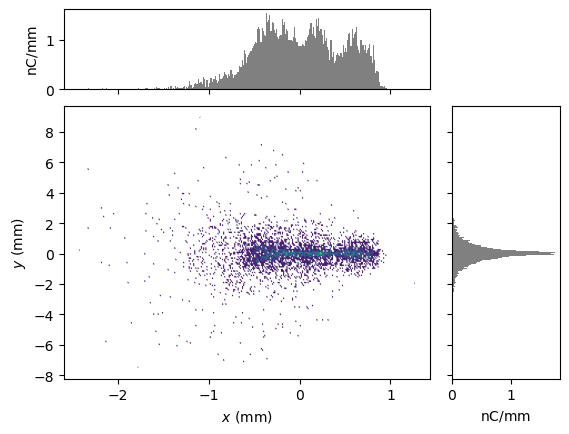

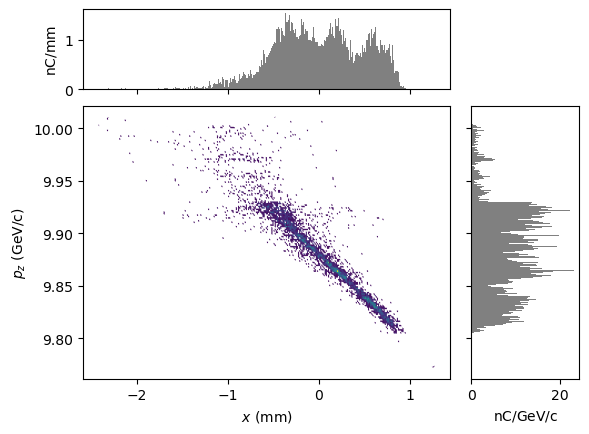

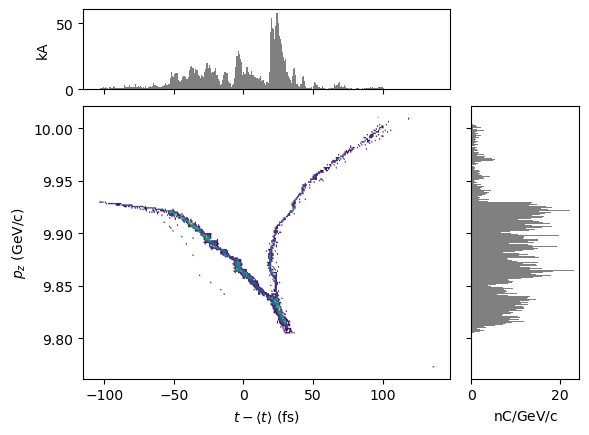

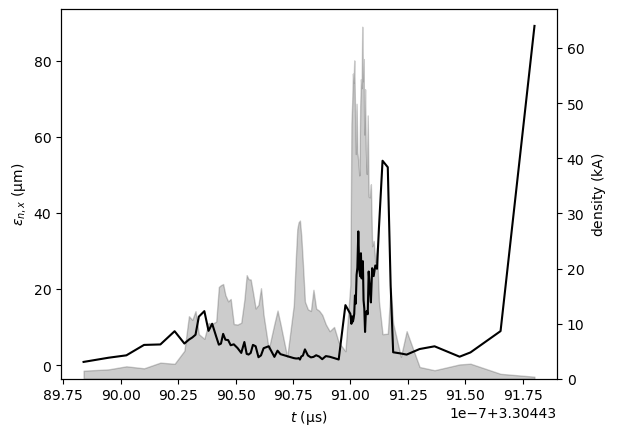

In [17]:
display(plotNMM(PPENT, 'x', 'y',  bins=300))
display(plotNMM(PPENT, 'x', 'pz', bins=300))
display(plotNMM(PPENT, 'delta_t', 'pz', bins=300))
display(slicePlotNMM(PPENT, 'norm_emit_x',n_slice=100))

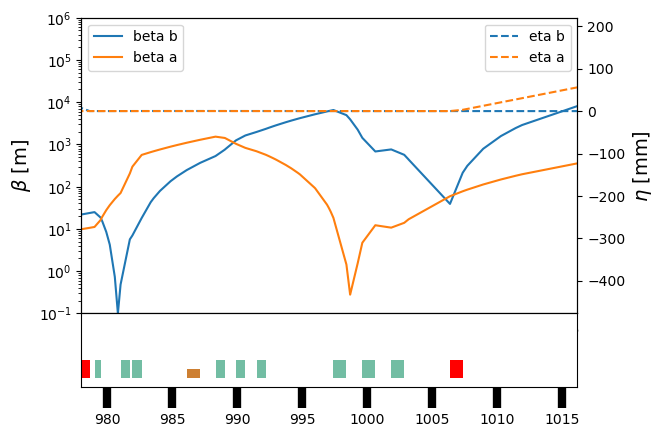

In [18]:
elements=tao.lat_ele_list();


floorplan=pd.read_csv(
    io.StringIO('\n'.join(tao.show('lat -all -floor_coords -tracking_elements')[3:-5])), 
    sep="[\s\n]+",
    engine='python',
    names=['Index','ElementName','ElementType','s','ds','X','Y','Z','Theta','Phi','Psi'])
floorplan.drop(0,inplace=True)


#Get twiss functions
tao.cmd('set global lattice_calc_on = T')
s=np.array([tao.lat_list(x,'ele.s')[0] for x in floorplan.Index])
x=np.array([tao.lat_list(x,'orbit.floor.x')[0] for x in floorplan.Index])
beta_y=np.array([tao.lat_list(x,'ele.a.beta')[0] for x in floorplan.Index])
beta_x=np.array([tao.lat_list(x,'ele.b.beta')[0] for x in floorplan.Index])
etot=np.array([tao.lat_list(x,'ele.e_tot')[0] for x in floorplan.Index])
eta_y=np.array([tao.lat_list(x,'ele.y.eta')[0] for x in floorplan.Index])
eta_x=np.array([tao.lat_list(x,'ele.x.eta')[0] for x in floorplan.Index])


fig = plt.figure(num=1,figsize=[3.375*5,3.375*2])
fig.clf()
ax,ax_fp=format_longitudinal_plot(fig)

ax.semilogy(s,beta_x,label='beta b')
ax.semilogy(s,beta_y,label='beta a')
plt.legend(loc=2)
ax.set_ylim([0.1,1e6])
ax_r=ax.twinx()
ax_r.plot(s,eta_x*1e3,'C0--',label='eta b')
ax_r.plot(s,eta_y*1e3,'C1--',label='eta a')
plt.legend(loc=1)
#ax_r.plot(s,beta_y,'k--')
#ax_r.plot(s,np.array([tao.lat_list(x,'ele.x.eta')[0] for x in floorplan.Index]),'--')

ax.set_facecolor('w')
zmin = 978
zmax = 1016.162829 #DTOTR S = 1016.162829

ax.set_xlabel('Z [m]',fontsize=14)
ax.set_ylabel(r'$\beta$ [m]',fontsize=14)
ax_r.set_ylabel(r'$\eta$ [mm]',fontsize=14)

ax.set_xlim([zmin,zmax])
ax_fp.set_ylim([-1,3])

plt.show()
#fig.savefig('beamline',transparent=False,bbox_inches='tight', dpi=300)

In [19]:
tao.cmd("set ele XTCAVF VOLTAGE = 10e6")
tao.cmd("set ele XTCAVF PHI0 = 0")
tao.cmd('set global track_type = beam') #set "track_type = single" to return to single particle
tao.cmd('set global track_type = single') #return to single to prevent accidental long re-evaluation


PTCAVOn = ParticleGroup(data=tao.bunch_data("DTOTR"))
PTCAVOn = PTCAVOn[PTCAVOn.status==1]


tao.cmd("set ele XTCAVF VOLTAGE = 0")
tao.cmd("set ele XTCAVF PHI0 = 0")
tao.cmd('set global track_type = beam') #set "track_type = single" to return to single particle
tao.cmd('set global track_type = single') #return to single to prevent accidental long re-evaluation


PTCAVOff = ParticleGroup(data=tao.bunch_data("DTOTR"))
PTCAVOff = PTCAVOff[PTCAVOff.status==1]

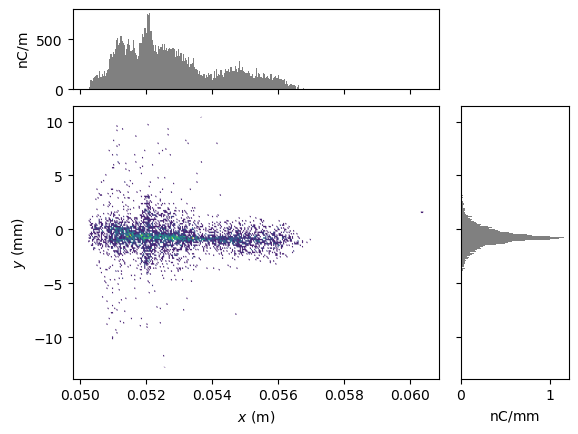

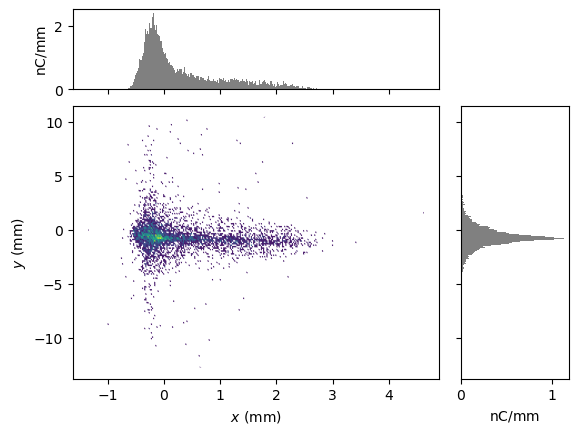

In [20]:
display(plotNMM(PTCAVOn, 'x', 'y', bins=300))
display(plotNMM(PTCAVOff, 'x', 'y', bins=300))

In [21]:
np.size(PTCAVOn[PTCAVOn.status==1].x)

10000

In [22]:
np.size(PTCAVOff[PTCAVOff.status==1].x)

10000

In [23]:
PMFFF =  ParticleGroup(data=tao.bunch_data("MFFF"))
PMFFF = PMFFF[PMFFF.status==1]

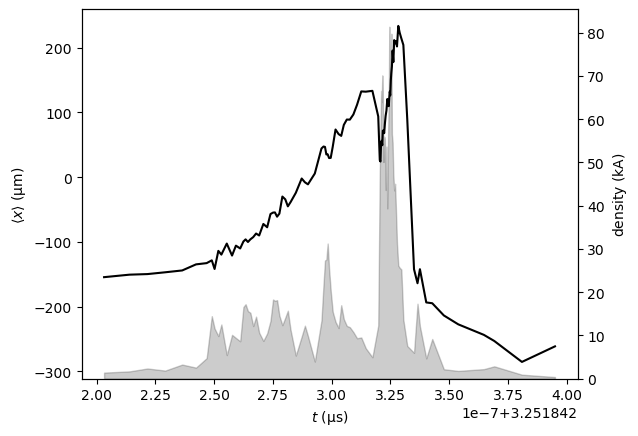

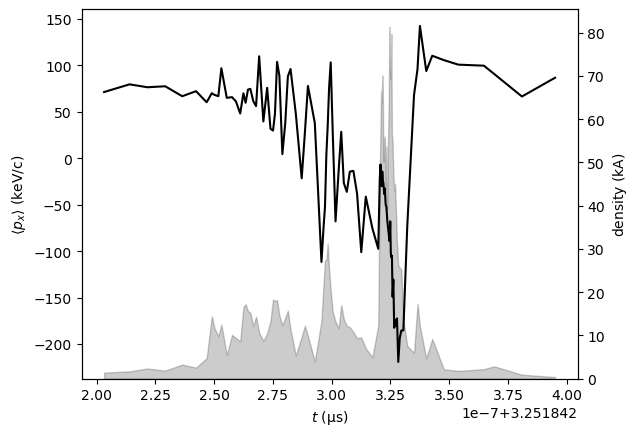

In [24]:
display(slicePlotNMM(PMFFF, 'mean_x',n_slice=100))
display(slicePlotNMM(PMFFF, 'mean_px',n_slice=100))